# Setup

In [9]:
from langgraph.graph import StateGraph
from langchain_groq import ChatGroq

from langchain_core.runnables import RunnableLambda
from langchain.prompts import ChatPromptTemplate
from duckduckgo_search import DDGS
from langchain_core.runnables.graph import MermaidDrawMethod


from typing import TypedDict
import graphviz
import os
import yaml

In [2]:
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
llm = ChatGroq(model_name='llama-3.3-70b-versatile',temperature=0)

# Estado

In [3]:
class State(TypedDict):
    pergunta: str  
    conteudo: str 
    resposta: str 

# Funções de CallBack

In [4]:
def recebe_pergunta(state: State) -> State:
    print(f"Usuário perguntou: {state['pergunta']}")
    return {"pergunta": state["pergunta"]}

def precisa_pesquisar(state: State) -> State:
    pergunta = state["pergunta"].lower()
    precisa = any(p in pergunta for p in ["dados", "estatísticas", "números", "pesquisa"])
    print("Precisa pesquisar?", precisa)
    # Retorna um dicionário, com chave especial para decisão
    return {"next_step": "pesquisar" if precisa else "consultar_llm"}

def pesquisar(state: State) -> State:
    pergunta = state["pergunta"]
    print(f"Pesquisando no DuckDuckGo: {pergunta}")

    with DDGS() as ddgs:
        resultados = ddgs.text(pergunta, max_results=1)

    if resultados:
        contexto = "\n".join([r["body"] for r in resultados if "body" in r])
    else:
        contexto = "Nenhum resultado encontrado."

    return {"conteudo": contexto}    

def consultar_llm(state: State) -> State:
    prompt = ChatPromptTemplate.from_template("Responda à seguinte pergunta: {pergunta}")
    chain = prompt | llm
    resposta = chain.invoke({"pergunta": state["pergunta"]})
    print("Resposta direta do LLM.")
    return {"resposta": resposta.content}

def sintetizar(state: State) -> State:
    contexto = state.get("conteudo", "")
    pergunta = state["pergunta"]
    prompt = ChatPromptTemplate.from_template("""
    Use o seguinte contexto para responder a pergunta:
    Contexto: {contexto}
    Pergunta: {pergunta}
    Resposta:""")
    chain = prompt | llm
    resposta = chain.invoke({"contexto": contexto, "pergunta": pergunta})
    print("Resposta sintetizada com contexto.")
    return {"resposta": resposta.content}

def responder(state: State) -> State:
    print("\n Resposta Final:")
    print(state["resposta"])
    return state

# Cria Grafo

In [5]:
graph = StateGraph(State)

graph.add_node("recebe_pergunta", RunnableLambda(recebe_pergunta))
graph.add_node("decisao", RunnableLambda(precisa_pesquisar))
graph.add_node("pesquisar", RunnableLambda(pesquisar))
graph.add_node("consultar_llm", RunnableLambda(consultar_llm))
graph.add_node("sintetizar", RunnableLambda(sintetizar))
graph.add_node("responder", RunnableLambda(responder))

# Transições de Estado e Condições

In [6]:
graph.set_entry_point("recebe_pergunta")

graph.add_edge("recebe_pergunta", "decisao")
graph.add_conditional_edges(
    "decisao",
    lambda state: state["next_step"],  
    {
        "pesquisar": "pesquisar",
        "consultar_llm": "consultar_llm"
    }
)
graph.add_edge("pesquisar", "sintetizar")
graph.add_edge("consultar_llm", "responder")
graph.add_edge("sintetizar", "responder")
graph.set_finish_point("responder")

# Execução

In [7]:
executable = graph.compile()

print("\n TESTE 1:")
executable.invoke({"pergunta": "Qual é a capital da Alemanha?"})

print("\n  TESTE 2:")
executable.invoke({"pergunta": "Me mostre dados sobre economia brasileira em 2025."})


 TESTE 1:
Usuário perguntou: Qual é a capital da Alemanha?
Precisa pesquisar? False
Resposta direta do LLM.

 Resposta Final:
Berlim.

  TESTE 2:
Usuário perguntou: Me mostre dados sobre economia brasileira em 2025.
Precisa pesquisar? True
Pesquisando no DuckDuckGo: Me mostre dados sobre economia brasileira em 2025.


/var/folders/gw/ttswwznn6hd6fpmml52b4sh40000gn/T/ipykernel_51764/1028576957.py:16: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


Resposta sintetizada com contexto.

 Resposta Final:
Até a data do meu último conhecimento em abril de 2023, não tenho informações específicas sobre a economia brasileira em 2025, pois meus dados são limitados a até 2023. No entanto, posso oferecer uma visão geral de como a economia brasileira tem se comportado nos anos anteriores e quais são os principais desafios e tendências que podem influenciar seu desempenho futuro.

A economia brasileira é uma das maiores da América Latina e do mundo, com um Produto Interno Bruto (PIB) significativo. Nos anos recentes, o Brasil enfrentou desafios econômicos, incluindo recessão, inflação, desemprego e uma grande dependência das exportações de commodities. O país também tem enfrentado questões estruturais, como uma burocracia complexa, altos impostos e uma infraestrutura que precisa de melhorias.

Para 2025, é provável que a economia brasileira continue a ser influenciada por fatores globais, como as tendências econômicas mundiais, os preços das c

{'pergunta': 'Me mostre dados sobre economia brasileira em 2025.',
 'conteudo': 'Apr 18, 2025 · google chrome官网入口Google Chrome官网的入口是：https://www.google.cn/chrome/以下是关于Google Chrome官网入口的一些重要信息和建议 ...',
 'resposta': 'Até a data do meu último conhecimento em abril de 2023, não tenho informações específicas sobre a economia brasileira em 2025, pois meus dados são limitados a até 2023. No entanto, posso oferecer uma visão geral de como a economia brasileira tem se comportado nos anos anteriores e quais são os principais desafios e tendências que podem influenciar seu desempenho futuro.\n\nA economia brasileira é uma das maiores da América Latina e do mundo, com um Produto Interno Bruto (PIB) significativo. Nos anos recentes, o Brasil enfrentou desafios econômicos, incluindo recessão, inflação, desemprego e uma grande dependência das exportações de commodities. O país também tem enfrentado questões estruturais, como uma burocracia complexa, altos impostos e uma infraestrutura que precisa de 

# Gráfico

In [8]:
dot = executable.get_graph().draw_mermaid()

print(dot)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	recebe_pergunta(recebe_pergunta)
	decisao(decisao)
	pesquisar(pesquisar)
	consultar_llm(consultar_llm)
	sintetizar(sintetizar)
	responder(responder)
	__end__([<p>__end__</p>]):::last
	__start__ --> recebe_pergunta;
	consultar_llm --> responder;
	decisao -.-> consultar_llm;
	decisao -.-> pesquisar;
	pesquisar --> sintetizar;
	recebe_pergunta --> decisao;
	sintetizar --> responder;
	responder --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [11]:
png_bytes = executable.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API
)

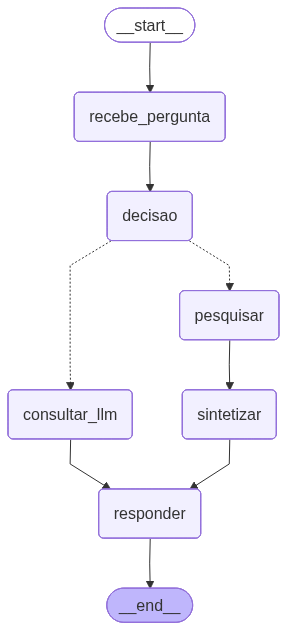

In [13]:
from IPython.display import Image  
Image(png_bytes)